In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import models, transforms, datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import kagglehub

In [16]:
# Detectar el dispositivo (GPU o CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando dispositivo: {device}")

Usando dispositivo: cuda


In [17]:
# Cargar dataset
dataset_path = "puneet6060/intel-image-classification"
path = kagglehub.dataset_download(dataset_path)

In [18]:
transform = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_data = datasets.ImageFolder(root=f"{path}/seg_train/seg_train", transform=transform)
test_data = datasets.ImageFolder(root=f"{path}/seg_test/seg_test", transform=transform)

train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

print(f"Clases encontradas: {train_data.classes}")

Clases encontradas: ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


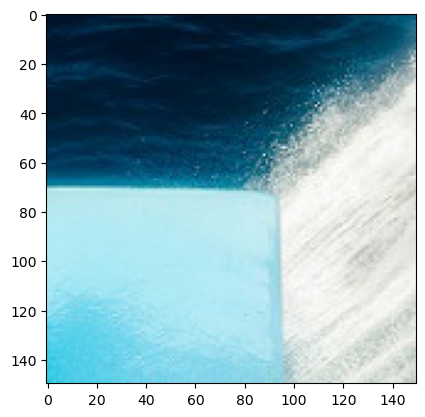

In [19]:
# 5. Vamos a visualizar una imagen del dataset
import matplotlib.pyplot as plt
import numpy as np

# Obtenemos una imagen del dataset
i = np.random.randint(len(train_data))
image, label = train_data[i]
image = image.unsqueeze(0).to(device)

plt.imshow(image.cpu().squeeze(0).permute(1, 2, 0).numpy() * 0.5 + 0.5)
plt.show()

In [20]:
# Transfer Learning con ResNet
model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
print(num_ftrs)
# Agregar capa lineal intermedia de 100 neuronas
model.fc = nn.Sequential(
    nn.Linear(num_ftrs, 100),  # Entrada: num_ftrs, Salida: 100
    nn.ReLU(),
    nn.Linear(100, len(train_data.classes))  # Entrada: 100, Salida: 6
)
model = model.to(device)

512


In [21]:
# 6. Predicción antes del entrenamiento
model.eval()
with torch.no_grad():
    output = model(image)  # Agregar dimensión batch
    _, pred = torch.max(output, 1)  # Índice de la mayor probabilidad

# Mostrar resultados
print(f"Etiqueta real: {train_data.classes[label]}")
print(f"Predicción del modelo: {train_data.classes[pred]}")

Etiqueta real: sea
Predicción del modelo: buildings


In [22]:

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [23]:
# Entrenamiento
train_losses = []
val_accuracies = []
epochs = 15

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(train_loader)
    train_losses.append(avg_loss)

    print(f'Epoch {epoch+1}, Loss: {running_loss/len(train_loader)}')

Epoch 1, Loss: 0.4137875770303336
Epoch 2, Loss: 0.3104876672341065
Epoch 3, Loss: 0.2422812762924216
Epoch 4, Loss: 0.20476970167999917
Epoch 5, Loss: 0.17972590405155311
Epoch 6, Loss: 0.1505946468731219
Epoch 7, Loss: 0.1215578649870374
Epoch 8, Loss: 0.10933920681391927
Epoch 9, Loss: 0.10718234589916062
Epoch 10, Loss: 0.06964046910659157
Epoch 11, Loss: 0.07588247319852764
Epoch 12, Loss: 0.0514022640730466
Epoch 13, Loss: 0.05681279170305722
Epoch 14, Loss: 0.0403244132533225
Epoch 15, Loss: 0.046845659304579554


In [31]:
 # Validación
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _,predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        #predicción despues del entrenamiento
        output = model(image)  # Agregar dimensión batch
        _,pred = torch.max(output, 1)  # Índice de la mayor probabilidad

val_accuracy = 100 * correct / total
val_accuracies.append(val_accuracy)

print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")
# Mostrar resultados
print(f"Etiqueta real: {train_data.classes[label]}")
print(f"Predicción del modelo: {train_data.classes[pred]}")



Epoch 15/15, Loss: 0.0468, Validation Accuracy: 88.70%
Etiqueta real: sea
Predicción del modelo: sea


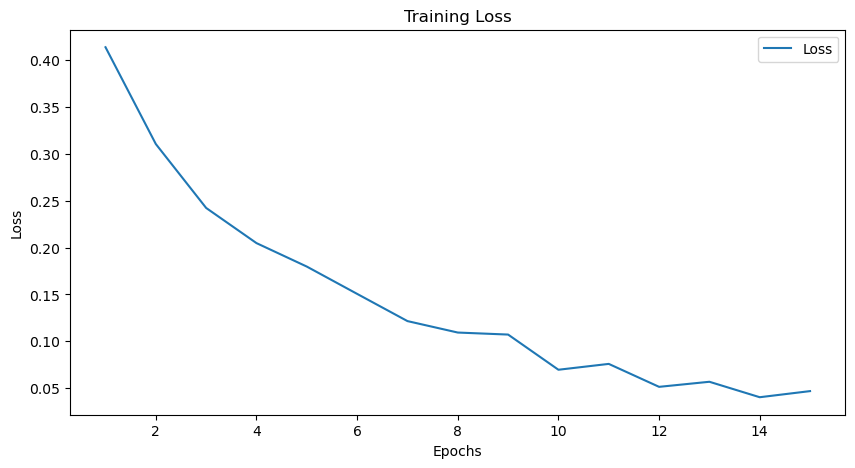

In [30]:

# Gráfica de pérdida
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs + 1), train_losses, label='Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.show()